In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from api.services.preprocessing import PreProcessing
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from mlflow.models import infer_signature
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import mlflow.sklearn
import joblib
import onnxruntime as ort
import time

/Users/elo/Desktop/EICNAM/1er année/ML/projet-ml/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preprocessing = PreProcessing()

Vectorizer loaded from save.


In [3]:
mlflow.set_experiment("svm_spoiler_detection")

<Experiment: artifact_location='file:///Users/elo/Desktop/EICNAM/1er%20anne%CC%81e/ML/projet-ml/mlruns/684303628867944363', creation_time=1742983922057, experiment_id='684303628867944363', last_update_time=1742983922057, lifecycle_stage='active', name='svm_spoiler_detection', tags={}>

In [4]:
X_train, y_train, X_test, y_test = preprocessing.get_dataset()

In [5]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Entraînement du modèle
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Évaluation du modèle
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy ({model_name}):", accuracy)
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        # Déterminer l'input_example pour MLflow
        input_example = X_train[:5]  # Prendre 5 exemples du dataset d'entraînement
        signature = infer_signature(X_train, model.predict(X_train))

        # Log metrics & modèle avec signature et input_example
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, f"{model_name}_model",
                                 signature=signature, input_example=input_example)

        # Sauvegarde en format Pickle
        joblib.dump(model, f"models/{model_name}_model.pkl")

        # Sauvegarde ONNX (sauf pour KNeighborsClassifier)
        if not isinstance(model, KNeighborsClassifier):
            onnx_model = convert_sklearn(model, initial_types=[("float_input", FloatTensorType([None, X_train.shape[1]]))])
            with open(f"models/{model_name}_model.onnx", "wb") as f:
                f.write(onnx_model.SerializeToString())
                mlflow.log_artifact(f"models/{model_name}_model.onnx")

        # Matrice de confusion
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        return y_pred, accuracy, conf_matrix


Entraînement du modèle : knn
----------------------------------------
Accuracy (knn): 0.6897212543554007

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      4231
           1       0.36      0.23      0.28      1509

    accuracy                           0.69      5740
   macro avg       0.56      0.54      0.54      5740
weighted avg       0.65      0.69      0.66      5740



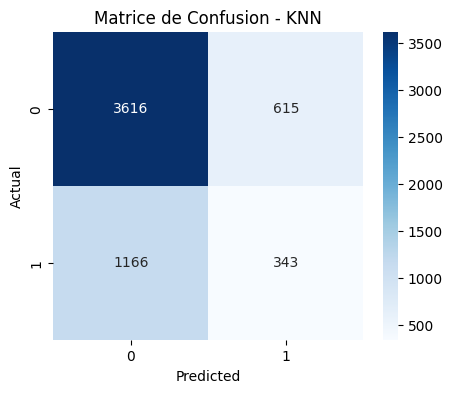


Entraînement du modèle : svm
----------------------------------------
Accuracy (svm): 0.7649825783972125

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.98      0.86      4231
           1       0.72      0.17      0.28      1509

    accuracy                           0.76      5740
   macro avg       0.75      0.57      0.57      5740
weighted avg       0.76      0.76      0.71      5740



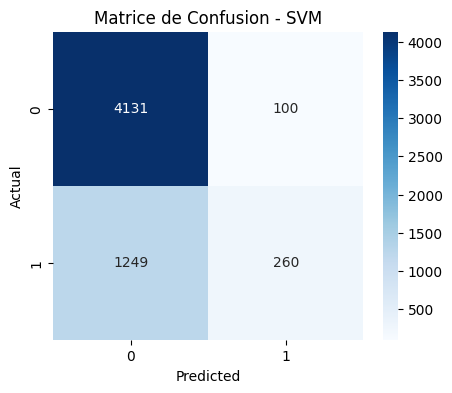


Entraînement du modèle : random_forest
----------------------------------------
Accuracy (random_forest): 0.7623693379790941

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86      4231
           1       0.77      0.14      0.23      1509

    accuracy                           0.76      5740
   macro avg       0.77      0.56      0.55      5740
weighted avg       0.76      0.76      0.69      5740



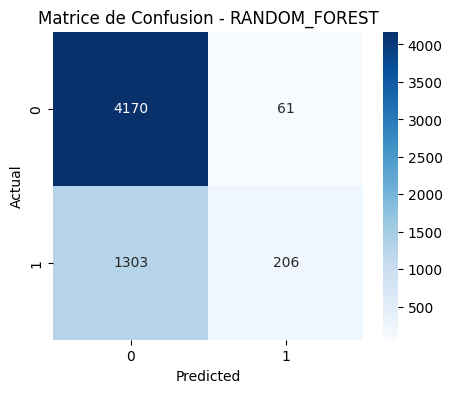


Entraînement du modèle : mlp
----------------------------------------


/Users/elo/Desktop/EICNAM/1er année/ML/projet-ml/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy (mlp): 0.7033101045296167

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      4231
           1       0.43      0.42      0.43      1509

    accuracy                           0.70      5740
   macro avg       0.61      0.61      0.61      5740
weighted avg       0.70      0.70      0.70      5740



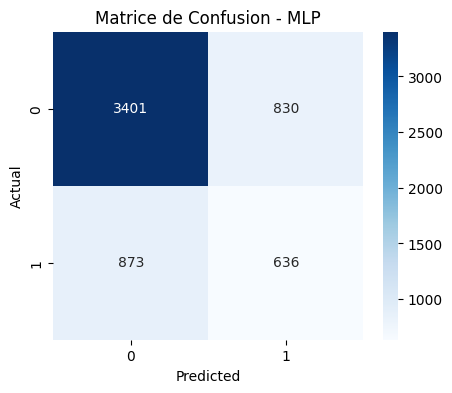

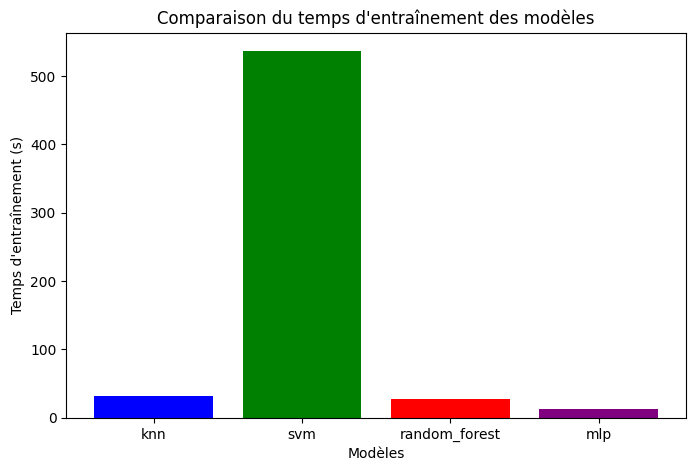

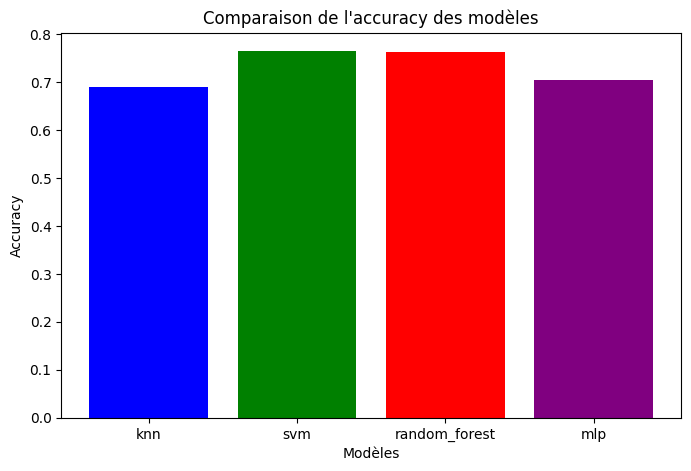


Modèle : KNN
Temps d'entraînement : 31.97 sec
Accuracy : 0.6897

Modèle : SVM
Temps d'entraînement : 536.92 sec
Accuracy : 0.7650

Modèle : RANDOM_FOREST
Temps d'entraînement : 27.23 sec
Accuracy : 0.7624

Modèle : MLP
Temps d'entraînement : 12.29 sec
Accuracy : 0.7033


In [6]:
# Liste des modèles
models = {
    "knn": KNeighborsClassifier(n_neighbors=5),
    "svm": SVC(kernel='rbf'),
    "random_forest": RandomForestClassifier(n_estimators=100),
    "mlp": MLPClassifier(hidden_layer_sizes=(10), max_iter=300)
}

# Stocker les temps d'entraînement et les performances
training_times = {}
accuracies = {}

# Boucle d'entraînement et d'évaluation
for model_name, model in models.items():
    print(f"\nEntraînement du modèle : {model_name}\n" + "-" * 40)
    start_time = time.time()
    
    # Entraînement et évaluation
    y_pred, accuracy, conf_matrix = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)
    
    # Stocker le temps et l'accuracy
    training_times[model_name] = time.time() - start_time
    accuracies[model_name] = accuracy
    
    # Affichage de la matrice de confusion
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matrice de Confusion - {model_name.upper()}')
    plt.show()
    
# Comparaison des temps d'entraînement
plt.figure(figsize=(8, 5))
plt.bar(training_times.keys(), training_times.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Modèles")
plt.ylabel("Temps d'entraînement (s)")
plt.title("Comparaison du temps d'entraînement des modèles")
plt.show()

# Comparaison des accuracy
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Modèles")
plt.ylabel("Accuracy")
plt.title("Comparaison de l'accuracy des modèles")
plt.show()

# Résumé des performances
for model_name in models.keys():
    print(f"\nModèle : {model_name.upper()}")
    print(f"Temps d'entraînement : {training_times[model_name]:.2f} sec")
    print(f"Accuracy : {accuracies[model_name]:.4f}")

In [7]:
def load_model_from_onnx(model_name):
    onnx_model = f"models/{model_name}_model.onnx"
    sess = ort.InferenceSession(onnx_model)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    return sess, input_name, output_name

def predict_with_onnx(model_name, sess, input_name, output_name, test_texts):
    pred_onnx = sess.run([output_name], {input_name: test_texts})[0]
    return pred_onnx

def ask_text():
    text = input("Entrez un texte : ")
    test_texts = preprocessing.prepare_text(text)
    return test_texts.toarray().astype(np.float32)

In [8]:
preprocessing.vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [9]:
sess, input_name, output_name = load_model_from_onnx("svm")
text = preprocessing.vectorizer.transform([
    """
    I love this movie but at the end we can see Aurore see her father. He killing her mother and she is sad.
    """
]).toarray().astype(np.float32)
predict_with_onnx("svm", sess, input_name, output_name, text)

array([1], dtype=int64)

In [10]:
# Prédiction avec le modèle ONNX
pred_onnx = predict_with_onnx("svm", sess, input_name, output_name, ask_text())
print(f"Prédiction ONNX : {pred_onnx}")

Prédiction ONNX : [0]


---

### Test paramétrage du MLP

In [11]:
model = MLPClassifier(hidden_layer_sizes=(10), max_iter=300)
print(f"\nEntraînement du modèle : {model_name}\n" + "-" * 40)
start_time = time.time()

# Entraînement et évaluation
y_pred, accuracy, conf_matrix = train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)

# Stocker le temps et l'accuracy
training_times = time.time() - start_time

print(f"\nModèle : {model_name.upper()}")
print(f"Temps d'entraînement : {training_times:.2f} sec")
print(f"Accuracy : {accuracy:.4f}")


Entraînement du modèle : mlp
----------------------------------------


/Users/elo/Desktop/EICNAM/1er année/ML/projet-ml/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy (mlp): 0.6925087108013938

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.80      4231
           1       0.40      0.36      0.38      1509

    accuracy                           0.69      5740
   macro avg       0.59      0.59      0.59      5740
weighted avg       0.68      0.69      0.69      5740


Modèle : MLP
Temps d'entraînement : 12.14 sec
Accuracy : 0.6925


---